# Zero-Shot Noise2Noise Experiment

[CVPR 2023: Zero-Shot Noise2Noise: Efficient Image Denoising without any Data](https://openaccess.thecvf.com/content/CVPR2023/papers/Mansour_Zero-Shot_Noise2Noise_Efficient_Image_Denoising_Without_Any_Data_CVPR_2023_paper.pdf)

Key idea: 
- the method is as simple as convolving the noisy image with two fixed kernels to create **a pair of downsampled images**. **A simple 2 layer CNN** is then trained with a **consistency loss**(regularization term) to map one downsampled image to the other.

limitation:
- This method is primarily suitable for **pixel-independent noise**, which may restrict its applicability to other types of noise or more complex scenarios. For instance, noise that is strongly correlated with signal strength like Poisson noise might not be well-suited for this method.


In [1]:
import os
import copy
import json
import time

import numpy as np
import matplotlib.pyplot as plt

from module.utils import calculate_metrics, display_image_in_detail, plot_2d_data, timer_decorator, display_4d_image, timer_decorator
from module.datasets import load_4d_dicom, save_4d_dicom, restore_data

from module.models import CNN, DnCNN, UNet
# from module.datasets import Nb2NbDataset
from module.loss import SSIMLoss, SSIM_MAELoss, SSIM_MSELoss


import h5py
from tqdm.notebook import tqdm


import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset

from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"device: {device}")

device: cuda:0


## Load preprocessed data

Noisy data...float32 (shape:(11, 24, 71, 192, 192); range:[0.0,1.0]; mean:0.4568054974079132); std:0.023385096341371536
{'original_min': -32768.0, 'original_max': 32767.0, 'z_score_mean': 201.4710693359375, 'z_score_std_dev': 1407.2664794921875, 'noise_min': -23.428024291992188, 'noise_max': 28.94860076904297}


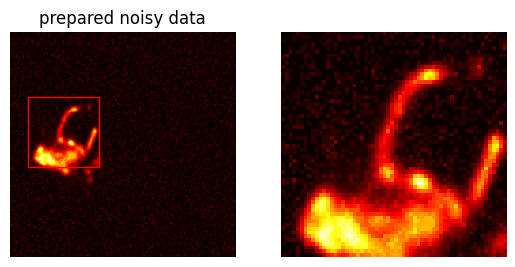

In [2]:
# load noisy data
with h5py.File('./dataset/preprocessed/PT_20p 150_120 OSEM_poisson_0.50_batch.h5', 'r') as f:
    noisy_data = f['dataset'][...]
    restore_info = json.loads(f['restore_info'][()])
    
print(f"Noisy data...{noisy_data.dtype} (shape:{noisy_data.shape}; range:[{np.min(noisy_data)},{np.max(noisy_data)}]; mean:{np.mean(noisy_data)}); std:{np.std(noisy_data)}")

print(restore_info)

display_image_in_detail(noisy_data[0, 11, 38], title="prepared noisy data")

In [3]:
#
val_tensor = torch.tensor(noisy_data[0, ..., np.newaxis, :, :, :], dtype=torch.float32) 
print(f"Validation tensor...{val_tensor.dtype} (shape:{val_tensor.shape}; range:[{torch.min(val_tensor)},{torch.max(val_tensor)}]; mean:{torch.mean(val_tensor)}); std:{torch.std(val_tensor)}")

Validation tensor...torch.float32 (shape:torch.Size([24, 1, 71, 192, 192]); range:[1.358317877020454e-05,0.965488076210022]; mean:0.4568372368812561); std:0.023439105600118637


## Import a simple network

In [4]:
in_chan = val_tensor.shape[1]
out_chan = 1

model = CNN(n_chan=in_chan, chan_embed=48, num_hidden_layers=2).to(device)
#model = DnCNN(in_chan, out_chan).to(device)
#model = UNet(in_chan, out_chan).to(device)

print("The number of parameters of the network is: ",  sum(p.numel() for p in model.parameters() if p.requires_grad))

summary(model, [(1, 192, 192)])

The number of parameters of the network is:  42097
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 192, 192]             480
         LeakyReLU-2         [-1, 48, 192, 192]               0
            Conv2d-3         [-1, 48, 192, 192]          20,784
         LeakyReLU-4         [-1, 48, 192, 192]               0
            Conv2d-5         [-1, 48, 192, 192]          20,784
         LeakyReLU-6         [-1, 48, 192, 192]               0
            Conv2d-7          [-1, 1, 192, 192]              49
Total params: 42,097
Trainable params: 42,097
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.14
Forward/backward pass size (MB): 81.28
Params size (MB): 0.16
Estimated Total Size (MB): 81.58
----------------------------------------------------------------


## Define Method Modules

The loss function is the sum of a residual loss plus a consistency loss as follows:

$$     \mathcal{L}_\mathrm{res.}(\theta) =\frac{1}{2}\left( \|D_1({y}) - f_{\theta}(D_1({y})) - D_2({y})\|_2^2 + \|D_2({y}) - f_{\theta}(D_2({y})) - D_1({y})\|_2^2 \right). $$

$$     \mathcal{L}_\mathrm{cons.}(\theta) = \frac{1}{2} \left( \|f_{\theta}(D_1({y})) - D_1(f_{\theta}({y}))\|_2^2 + \|f_{\theta}(D_2({y})) - D_2(f_{\theta}({y}))\|_2^2 \right). $$

$$ \mathcal{L}(\theta) = \mathcal{L}_\mathrm{res.}(\theta) + \mathcal{L}_\mathrm{cons.}(\theta), $$

where $y$ is the noisy input image, $D$ is the image pair downsampler, and $f_\theta$ is the network.

In [5]:
# define down-sampler 
def pair_downsampler(img):
    #img has shape B C H W
    c = img.shape[1]

    filter1 = torch.FloatTensor([[[[0 ,0.5],[0.5, 0]]]]).to(img.device)
    filter1 = filter1.repeat(c,1, 1, 1)

    filter2 = torch.FloatTensor([[[[0.5 ,0],[0, 0.5]]]]).to(img.device)
    filter2 = filter2.repeat(c,1, 1, 1)

    output1 = F.conv2d(img, filter1, stride=2, groups=c)
    output2 = F.conv2d(img, filter2, stride=2, groups=c)

    return output1, output2


# mean square error 
def mse(gt: torch.Tensor, pred:torch.Tensor)-> torch.Tensor:
    loss = torch.nn.MSELoss()
    return loss(gt,pred)


# loss function
def loss_func(noisy_img):
    noisy1, noisy2 = pair_downsampler(noisy_img)

    pred1 =  noisy1 - model(noisy1)
    pred2 =  noisy2 - model(noisy2)

    loss_res = 1/2*(mse(noisy1,pred2)+mse(noisy2,pred1))

    noisy_denoised =  noisy_img - model(noisy_img)
    denoised1, denoised2 = pair_downsampler(noisy_denoised)

    loss_cons=1/2*(mse(pred1,denoised1) + mse(pred2,denoised2))

    loss = loss_res + loss_cons

    return loss

In [6]:
def train(model, optimizer, noisy_img):

  loss = loss_func(noisy_img)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return loss.item()

def test(model, noisy_img, clean_img):

    with torch.no_grad():
        pred = torch.clamp(noisy_img - model(noisy_img),0,1)
        MSE = mse(clean_img, pred).item()
        PSNR = 10*np.log10(1/MSE)

    return PSNR

def denoise(model, noisy_img):

    with torch.no_grad():
        pred = torch.clamp( noisy_img - model(noisy_img),0,1)

    return pred



## Example denoising

gaussian 0.50 test

| Max Epoch | Num Hidden Layers | PSNR       | SSIM   | MAE       | BRISQUE |
|-----------|-------------------|------------|--------|-----------|---------|
| 2000      | 2                 | 31.2335    | 0.5798 | 0.01108   | 155.845 |
| **2000**      | **3**                 | 31.3068    | 0.5821 | 0.01083   | 155.845 |
| 2000      | 4                 | 31.2262    | 0.5789 | 0.01076   | 155.845 |
| 4000      | 2                 | 31.1647    | 0.5727 | 0.01100   | 155.845 |
| **4000**     | **3**                 | 30.8310    | 0.5558 | 0.01137   | 155.845 |
| 4000      | 4                 | 30.9221    | 0.5568 | 0.01114   | 155.845 |
| 6000      | 2                 | 31.0026    | 0.5643 | 0.01113   | 155.845 |
| **6000**      | **3**                 | 30.7387    | 0.5444 | 0.01145   | 155.845 |
| 6000      | 4                 | 31.3118    | 0.5943 | 0.01199   | 155.845 |
| 8000      | 2                 | 30.9544    | 0.5603 | 0.01127   | 155.845 |
| 8000      | 3                 | 30.9203    | 0.5614 | 0.01132   | 155.845 |
| **8000**      | **4**                 | 30.6344    | 0.5543 | 0.01165   | 155.845 |


In [7]:
time_idx = 11
depth_idx = 38

noisy_img = val_tensor[time_idx, :, depth_idx, :, :].unsqueeze(0).to(device)

print(f"noisy_img: {noisy_img.shape} ")

noisy_img: torch.Size([1, 1, 192, 192]) 


the image pair downsampler which outputs two downsampled images of half the spatial resolution by averaging diagonal pixels in non-overlapping patches, as shown in the below figure.

It is realised by convolving the image with the 2 fixed kernels: $k_1 = \begin{bmatrix}0 & 0.5 \\0.5 & 0\end{bmatrix}$ and $k_2 = \begin{bmatrix}0.5 & 0 \\0 & 0.5\end{bmatrix}$, where the convolution has stride=2, and is applied to each image channel separately.


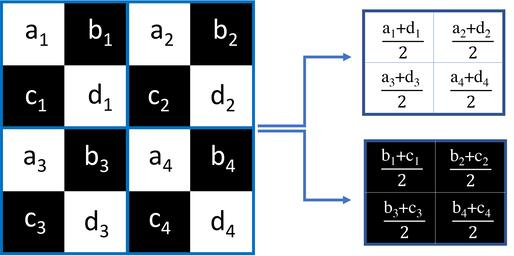

Text(0.5, 1.0, 'Second downsampled')

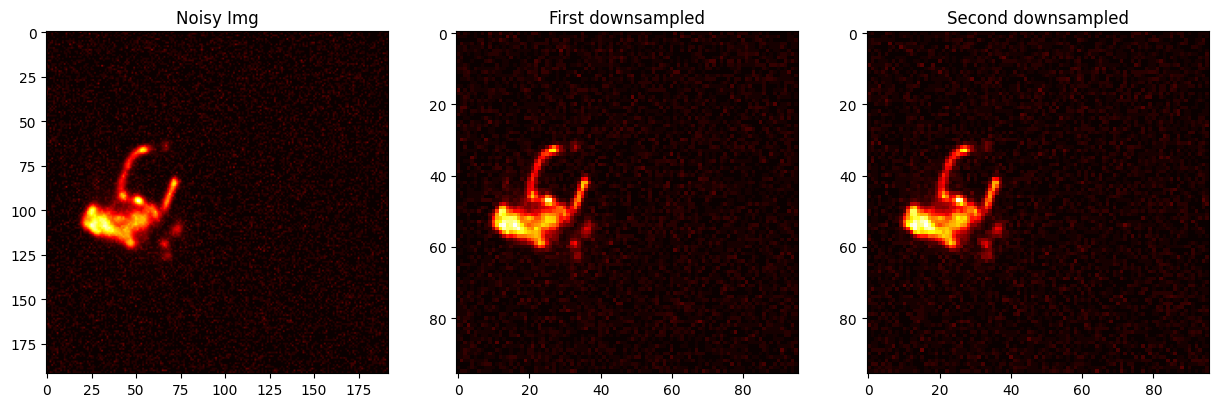

In [8]:
# down-sampler example
img1, img2 = pair_downsampler(noisy_img)

img0 = noisy_img.cpu().squeeze(0).permute(1,2,0)
img1 = img1.cpu().squeeze(0).permute(1,2,0)
img2 = img2.cpu().squeeze(0).permute(1,2,0)

fig, ax = plt.subplots(1, 3,figsize=(15, 15))

ax[0].imshow(img0, cmap='hot')
ax[0].set_title('Noisy Img')

ax[1].imshow(img1, cmap='hot')
ax[1].set_title('First downsampled')

ax[2].imshow(img2, cmap='hot')
ax[2].set_title('Second downsampled')

In [49]:
max_epoch = 8000     # training epochs
lr = 0.001           # learning rate
step_size = 1500     # number of epochs at which learning rate decays
gamma = 0.7         # factor by which learning rate decays


model = CNN(n_chan=in_chan, chan_embed=48, num_hidden_layers=4).to(device)
print("The number of parameters of the network is: ",  sum(p.numel() for p in model.parameters() if p.requires_grad))

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

The number of parameters of the network is:  83665


In [50]:
pbar = tqdm(range(max_epoch))
for epoch in pbar:
    
    loss = train(model, optimizer, noisy_img)
    scheduler.step()
    pbar.set_description(f"Epoch {epoch+1}, Loss: {loss:.4f}")

  0%|          | 0/8000 [00:00<?, ?it/s]

noisy: (192, 192, 1) range:(0.44456586241722107, 0.915052056312561); mean:0.4617355167865753; std:0.04128936305642128
denoised: (192, 192, 1) range:(0.4341302514076233, 0.9033250212669373); mean:0.46159860491752625; std:0.03894459083676338
data range: 0.47048619389533997
calculate_metrics running: 0.04008169996086508 second
PSNR: 30.634455570693497; SSIM: 0.5543084843434175; MAE: 0.01165479514747858; BRISQUE: 155.845


Text(0.5, 1.0, 'diff')

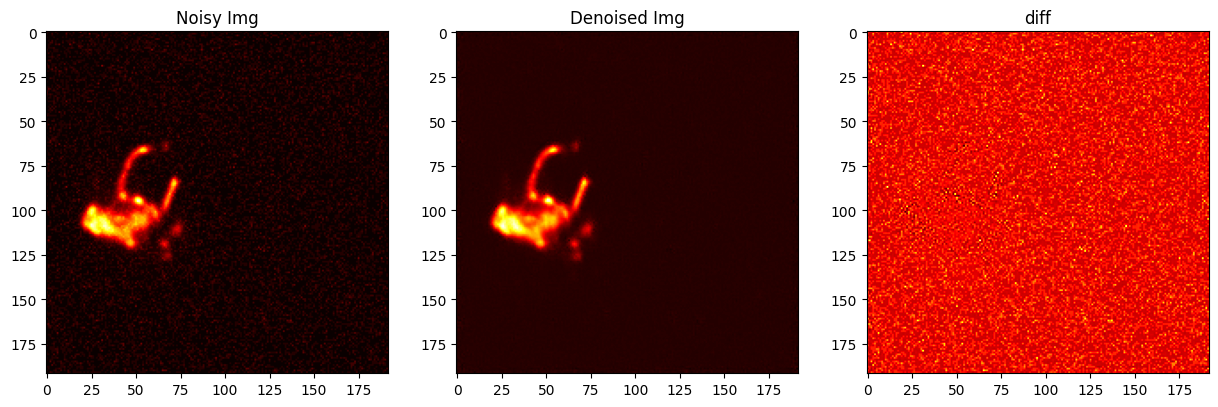

In [51]:
# prediction
denoised_img = denoise(model, noisy_img)

#
noisy = noisy_img.cpu().squeeze(0).permute(1,2,0).numpy()
denoised = denoised_img.cpu().squeeze(0).permute(1,2,0).numpy()
 

print(f"noisy: {noisy.shape} range:({np.min(noisy)}, {np.max(noisy)}); mean:{np.mean(noisy)}; std:{np.std(noisy)}")
print(f"denoised: {denoised.shape} range:({np.min(denoised)}, {np.max(denoised)}); mean:{np.mean(denoised)}; std:{np.std(denoised)}")

#
data_range_noisy = np.max(noisy) - np.min(noisy)
data_range_denoised = np.max(denoised) - np.min(denoised)
data_range = max(data_range_noisy, data_range_denoised)
print(f"data range: {data_range}")

psnr_values, ssim_values, mae_values, brisque_values = calculate_metrics(np.squeeze(noisy), np.squeeze(denoised), data_range=data_range)

psnr_values[np.isinf(psnr_values)] = np.nan # set inf value to nan

print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.sum(mae_values)}; BRISQUE: {np.nanmean(brisque_values)}")

 
# 
fig, ax = plt.subplots(1, 3,figsize=(15, 15))
 
ax[0].imshow(noisy, cmap='hot')
ax[0].set_title('Noisy Img')


ax[1].imshow(denoised, cmap='hot')
ax[1].set_title('Denoised Img')

ax[2].imshow(noisy - denoised, cmap='hot')
ax[2].set_title('diff')


## Process denoising

In [52]:
max_epoch = 4000     # training epochs
lr = 0.001           # learning rate
step_size = 1500     # number of epochs at which learning rate decays
gamma = 0.5          # factor by which learning rate decays

# optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# model = CNN(n_chan=in_chan, chan_embed=48, num_hidden_layers=3).to(device)
# print("The number of parameters of the network is: ",  sum(p.numel() for p in model.parameters() if p.requires_grad))

In [57]:
denoised_tensor = torch.zeros_like(val_tensor)

total_iterations = val_tensor.shape[0] * val_tensor.shape[2]
pbar = tqdm(total=total_iterations, desc='Processing', ncols=100)

for b in range(val_tensor.shape[0]):
    for d in range(val_tensor.shape[2]):
        # zero-shot denoising
        noisy = val_tensor[b, :, d].unsqueeze(0).to(device)
        
        # reset model, optimizer, scheduler
        model = CNN(n_chan=in_chan, chan_embed=48, num_hidden_layers=3).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        # train on single noisy image
        for epoch in range(max_epoch):
            train(model, optimizer, noisy)
            scheduler.step()
        # prediction
        denoised = denoise(model, noisy)
        # add denoised tensor
        denoised_tensor[b, :, d] = denoised.cpu().squeeze(0)
        pbar.update(1)
         
pbar.close()

Processing:   0%|                                                          | 0/1704 [00:00<?, ?it/s]

## mertics evaluation

In [ ]:
denoised_data = preds[0].squeeze(1).numpy()
true_data = targets[0].squeeze(1).numpy()

print(f"denoised data: {denoised_data.dtype}; shape:{denoised_data.shape}; range:({np.min(denoised_data)},{np.max(denoised_data)}); mean:{np.mean(denoised_data)}; std:{np.std(denoised_data)}")
print(f"true_data data: {true_data.dtype}; shape:{true_data.shape}; range:({np.min(true_data)},{np.max(true_data)}); mean:{np.mean(true_data)}; std:{np.std(true_data)}")


# example plot
data_range_true = np.max(true_data[11, 38]) - np.min(true_data[11, 38])
data_range_denoised = np.max(denoised_data[11, 38]) - np.min(denoised_data[11, 38])
data_range = max(data_range_true, data_range_denoised)
print(f"data range: {data_range}")
psnr_values, ssim_values, mae_values, brisque_values = calculate_metrics(denoised_data[11, 38], true_data[11, 38], data_range=data_range)
print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.sum(mae_values)}; BRISQUE: {np.mean(brisque_values)}")

display_image_in_detail(denoised_data[11, 38], title='denoised')
display_image_in_detail(true_data[11, 38], title='true')

## 6. metrics evaluation

In [ ]:
data_range_true = np.max(true_data) - np.min(true_data)
data_range_denoised = np.max(denoised_data) - np.min(denoised_data)
data_range = max(data_range_true, data_range_denoised)
print(f"data range: {data_range}")

#
psnr_values, ssim_values, mae_values, brisque_values = calculate_metrics(denoised_data, true_data, data_range=data_range)

psnr_values[np.isinf(psnr_values)] = np.nan # set inf value to nan

print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.sum(mae_values)}; BRISQUE: {np.nanmean(brisque_values)}")

# Save denormalized denoised data into 16-bit DICOM files

In [ ]:
# denormalized denoised data
restored_data = restore_data(denoised_data, restore_info)
print(f"restore_data: {restored_data.dtype} shape:{restored_data.shape}; range:({np.min(restored_data)},{np.max(restored_data)}); mean:{np.mean(restored_data)}; std:{np.std(restored_data)}")
display_image_in_detail(restored_data[11, 38], title="restored")

In [ ]:
# save denormalized denoised data as 16-bit gray-scale .DICOM files
origin_dicom_folder = './dataset/10_05_2021_PET_only/PT_20p 150_120 OSEM'

output_folder = './dataset/denoised/N2V/PT_20p 150_120 OSEM_poisson_0.35'

save_4d_dicom(origin_dicom_folder, restored_data, output_folder)